# Vaccinazioni ed Rt

Correlazione vaccinazioni ed Rt in Italia e nel mondo.

> Max Pierini

***

Si presenta una semplice analisi esplorativa della correlazione tra percentuale di vaccinati (singola dose o doppia dose) e numero di riproduzione effettivo $R_t$ (stimato con metodo EpiEstim su nuovi casi totali) in Italia e nel mondo (per le nazioni di cui sia nota la percentuale di vaccinati e l'incidenza di casi COVID-19).

> **NOTA BENE:** la correlazione sarà significativa solo nel momento in cui in Italia e/o in un numero sufficiente di nazioni sarà raggiunta una percentuale di vaccinazioni adeguata a sortire un effetto misurabile nell'interruzione della catena di trasmissione (indicativamente, almeno 25%)

Dato il numero di riproduzione di base $R_0 \simeq 3$ medio stimato per COVID-19 e l'efficacia vaccinale dei vaccini a mRNA attualmente nota per la somministrazione completa (due dosi) $E=95\%$, la minima copertura vaccinale $V$ da raggiungere per effetto gregge è pari a

$$
V = \frac{1 - \frac{1}{R_0}}{E} \simeq 70\%
$$

> **NOTA BENE**: il numero di riproduzione effettivo $R_t$ può essere influenzato da altre cause quali: interventi non farmacologici (regole di distanziamento, uso di protezioni individuali, lockdown ecc), varianti virali a maggior trasmissibilità, ecc.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

from IPython.display import Markdown

In [2]:
cov = pd.read_csv(
    'https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'], index_col='data'
)
cov.index = cov.index.normalize()

In [3]:
tot = cov.totale_casi.values[0]

In [4]:
pop = pd.read_csv('pop_16.csv')

In [5]:
popolazione_italia = pop[pop.regione=='Italia'].popolazione.values[0]

pop_it = popolazione_italia - tot

In [6]:
vax_ts = pd.read_csv(
    'https://github.com/italia/covid19-opendata-vaccini/raw/master/dati/somministrazioni-vaccini-latest.csv',
    parse_dates=['data_somministrazione']
)

it_ts = vax_ts.groupby('data_somministrazione').sum()

In [7]:
vax_cum = it_ts.cumsum()

In [8]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end, ignore_under=50):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        if incid_sum > ignore_under and t_end[t] > final_mean_si:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + np.sum(_lambda[t_start[t]:t_end[t]+1]))
        else:
            a_posterior[t] = 0.1
            b_posterior[t] = 1.0
    return a_posterior, b_posterior

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 ignore_under=50,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        #print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        #print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - .99) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    #SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_x = np.arange(0, incid.size, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_tot = SI_y / SI_y.sum()
    #SI_tot = SI_y[1:]
    # pad SI with zeros
    #SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2    # shape
    b_prior = (sd_prior ** 2) / mu_prior    # scale
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end,
        ignore_under=ignore_under)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    #offset_idx = int(np.floor(window/2))
    res_index = idx[window:]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:
        fig, ax = plt.subplots(figsize=(12, 5))
        _ = res.plot(y='R', ax=ax, color='k')
        ax.fill_between(
            res_index,
            quantile_lo_posterior, quantile_hi_posterior,
            color='k', alpha=.2,
            label=f'CI {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ylim = ax.get_ylim()
        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method), window {window} days',
                  #f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days',
            ylim=(0, min(12, ylim[1])),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='lower left')
        plt.show()
    
    return res

In [9]:
ISS_sh = 1.87
ISS_ra = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def generation_time_gamma(sh, ra, plot=True, title='Estimated', size=None):

    dist = sps.gamma(a=sh, scale=1/ra)

    if size == None:
        max_x = int(np.ceil(dist.ppf(.9999)))
    else:
        max_x = size
    x = np.linspace(0, max_x, max_x+1)
    y = dist.pdf(x)
    y /= y.sum()
    
    mu, sd = gamma_mu_sd_from_shape_rate(sh, ra)
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(x, y, alpha=.5)
        ax.plot(x, y)
        ax.axvline(mu, color='r', ls='--', label=f'mean {mu:.1f} days')
        ax.legend()
        ax.set(
            title=f'{title} COVID-19 Generation Interval '+\
                  f'shape={sh:.3f}, rate={ra:.3f}',
            xlabel='days',
            ylabel='probability density'
        )
        plt.show()

    return x, y, mu, sd

# Italia

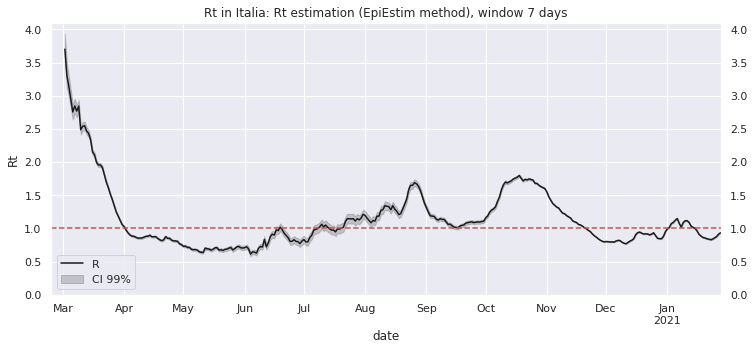

In [10]:
Rt = epi_estim_Rt(
    cov.nuovi_positivi, 
    SI_sh=ISS_sh, 
    SI_ra=ISS_ra, 
    window=7, 
    plot_Rt=True,
    title='Rt in Italia'
)

In [11]:
vax_pct = vax_cum[['prima_dose', 'seconda_dose']] / pop_it * 100

In [12]:
Rt_vax = Rt.merge(
    vax_pct,
    left_index=True, right_index=True
)

In [13]:
Rt_vax.loc[Rt_vax.seconda_dose==0, 'seconda_dose'] = np.nan

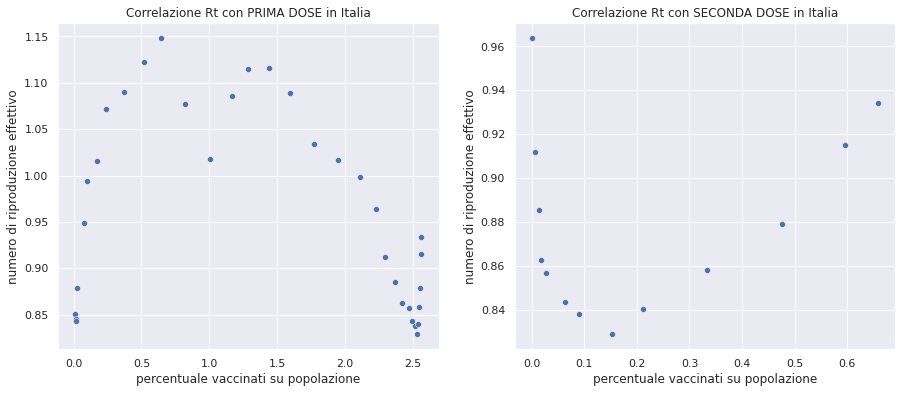

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=Rt_vax,
    x='prima_dose', y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ax=ax[0]
)
ax[0].set(
    title='Correlazione Rt con PRIMA DOSE in Italia',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)

sns.scatterplot(
    data=Rt_vax,
    x='seconda_dose', y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ax=ax[1]
)
ax[1].set(
    title='Correlazione Rt con SECONDA DOSE in Italia',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
plt.show()

# Mondo

In [15]:
vax_www = pd.read_csv(
    'https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/vaccinations.csv',
    parse_dates=['date']
)

In [16]:
cov_www = pd.read_csv(
    'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
)

In [17]:
vax_cols = ['location', 'date', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred']

In [18]:
errors = []
RT_VAX = None
for country in cov_www['Country/Region'].unique():
    if country == 'US':
        country = 'United States'
    if country not in vax_www.location.values:
        errors.append(country)
        continue
    _cov = cov_www[cov_www['Country/Region']==country].sum()
    _I = pd.DataFrame(_cov.T[4:]).diff()[1:]
    _I.columns = ['incidence']
    _I.index = pd.to_datetime(_I.index)
    _I.index.name = 'date'
    _I = _I.astype(int)
    Rt = epi_estim_Rt(
        _I, 
        SI_sh=ISS_sh, 
        SI_ra=ISS_ra, 
        window=7, 
        plot_Rt=False,
    )
    _merge = vax_www[vax_www.location==country][vax_cols].merge(
        Rt,
        left_on='date', right_index=True
    )
    if RT_VAX is None:
        RT_VAX = _merge
    else:
        RT_VAX = RT_VAX.append(_merge)

In [19]:
countries = RT_VAX.location.unique()

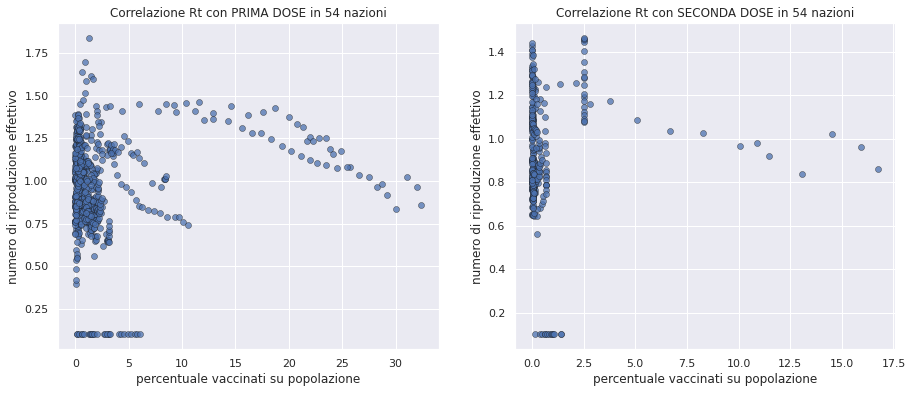

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=RT_VAX,
    x='people_vaccinated_per_hundred',
    y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[0]
)
ax[0].set(
    title=f'Correlazione Rt con PRIMA DOSE in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)

sns.scatterplot(
    data=RT_VAX,
    x='people_fully_vaccinated_per_hundred',
    y='R',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[1]
)
ax[1].set(
    title=f'Correlazione Rt con SECONDA DOSE in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
plt.show()

In [21]:
for c in RT_VAX.location.unique():
    _c = RT_VAX[RT_VAX.location==c]
    Rt0 = _c.R.values.ravel()[0]
    RT_VAX.loc[RT_VAX.location==c, 'R_var'] = RT_VAX.R - Rt0

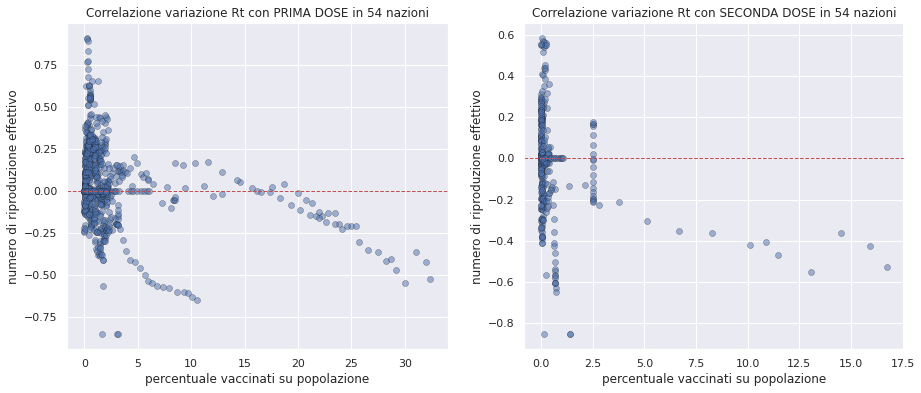

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=RT_VAX,
    x='people_vaccinated_per_hundred',
    y='R_var',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.5,
    ax=ax[0]
)
ax[0].axhline(0, color='r', ls='--', lw=1)
ax[0].set(
    title=f'Correlazione variazione Rt con PRIMA DOSE in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)

sns.scatterplot(
    data=RT_VAX,
    x='people_fully_vaccinated_per_hundred',
    y='R_var',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.5,
    ax=ax[1]
)
ax[1].axhline(0, color='r', ls='--', lw=1)
ax[1].set(
    title=f'Correlazione variazione Rt con SECONDA DOSE in {countries.size} nazioni',
    xlabel='percentuale vaccinati su popolazione',
    ylabel='numero di riproduzione effettivo'
)
plt.show()

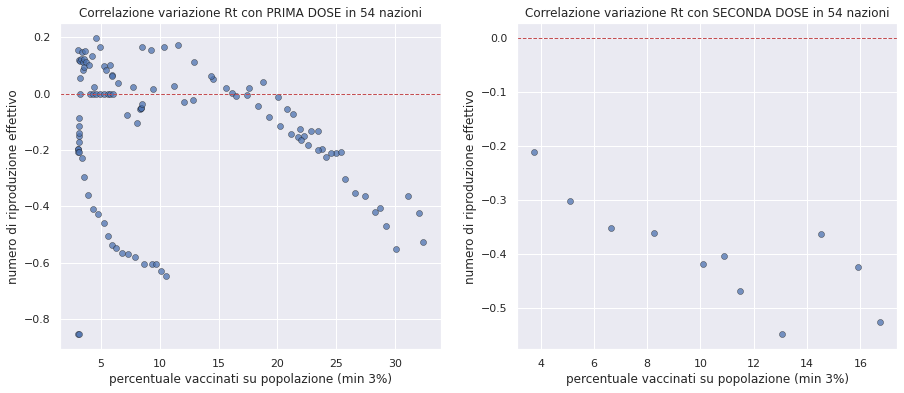

In [23]:
min_pct = 3

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(
    data=RT_VAX[RT_VAX.people_vaccinated_per_hundred>=min_pct],
    x='people_vaccinated_per_hundred',
    y='R_var',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[0]
)
ax[0].axhline(0, color='r', ls='--', lw=1)
ax[0].set(
    title=f'Correlazione variazione Rt con PRIMA DOSE in {countries.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct}%)',
    ylabel='numero di riproduzione effettivo'
)

sns.scatterplot(
    data=RT_VAX[RT_VAX.people_fully_vaccinated_per_hundred>=min_pct],
    x='people_fully_vaccinated_per_hundred',
    y='R_var',
    #scatter_kws=dict(s=10),
    #line_kws=dict(color='r'),
    ec='k',
    alpha=.75,
    ax=ax[1]
)
ax[1].axhline(0, color='r', ls='--', lw=1)
ax[1].set(
    title=f'Correlazione variazione Rt con SECONDA DOSE in {countries.size} nazioni',
    xlabel=f'percentuale vaccinati su popolazione (min {min_pct}%)',
    ylabel='numero di riproduzione effettivo'
)
plt.show()

In [24]:
print('NAZIONI:')
for i, c in enumerate(countries):
    print(i+1, c)

NAZIONI:
1 Argentina
2 Austria
3 Bahrain
4 Belgium
5 Brazil
6 Bulgaria
7 Canada
8 Chile
9 China
10 Costa Rica
11 Croatia
12 Cyprus
13 Czechia
14 Denmark
15 Ecuador
16 Estonia
17 Finland
18 France
19 Germany
20 Greece
21 Hungary
22 Iceland
23 India
24 Indonesia
25 Ireland
26 Israel
27 Italy
28 Kuwait
29 Latvia
30 Lithuania
31 Luxembourg
32 Malta
33 Mexico
34 Netherlands
35 Norway
36 Oman
37 Panama
38 Poland
39 Portugal
40 Romania
41 Russia
42 Saudi Arabia
43 Serbia
44 Seychelles
45 Singapore
46 Slovakia
47 Slovenia
48 Spain
49 Sweden
50 Switzerland
51 Turkey
52 United States
53 United Arab Emirates
54 United Kingdom
